In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import os
import os.path as osp
from tqdm import tqdm
import shutil 
import sys
import argparse
import pickle
from collections import OrderedDict

from utils import *
from models import *

import matplotlib.pyplot as plt
plt.style.use('default')

In [56]:
gpu_id='0'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  0


In [57]:
def select_model(model_name):
    if model_name=='deeponet':
        return deeponet
    elif model_name=='shiftdeeponet':
        return shiftdeeponet
    elif model_name=='flexdeeponet':
        return flexdeeponet
    elif model_name=='NOMAD':
        return NOMAD
    elif model_name=='hyperdeeponet':
        return hyperdeeponet
    

In [169]:
#name = 'SIRv2_121_DeepONet_mse'
#name = 'SIRv2_121_DeepONet_mse_rec'
#name = 'SIRv2_121_hyperdeeponet_mse_rec'

#name = 'SIRv3_int_11_DeepONet_rec'
#name = 'SIRv3_int_11_hyperdeepoent_rec'

name = 'SIRv4_int_11_hyperdeepoent_rec'

In [170]:
path=os.path.join('results',name)
args=torch.load(os.path.join(path,'args.bin'))
state_dict=torch.load(os.path.join(path,'weight.bin'))
loss_dict=torch.load(os.path.join(path,'loss.bin'))
model_name = 'small '+args.model if 'small' in name else args.model

In [171]:
args

Namespace(a_hyper='tanh', a_target='tanh', batch=20000, d_hyper=2, d_in=1, d_out=3, d_target=2, data='SIR_v4_rec', epochs=20000, gamma=0.0001, gpu_idx=0, load_path=None, lr=0.001, model='hyperdeeponet', multgpu=False, n_basis=10, n_sensor=121, name='SIRv4_int_11_hyperdeepoent_rec', sche_type='inversetime', seed=1, step_size=1, w_hyper=20, w_target=20, wd=0.0)

## Train Result

In [164]:
if 'rel_test_rec' in loss_dict:
    print("[last] S : %.5f I : %.5f Rec : %.5f" %(loss_dict['rel_test_S'][-1],loss_dict['rel_test_I'][-1],loss_dict['rel_test_rec'][-1]))
    print("[best] S : %.5f I : %.5f Rec : %.5f" %(min(loss_dict['rel_test_S']),min(loss_dict['rel_test_I']),min(loss_dict['rel_test_rec'])))
else:
    print("[last] S : %.5f I : %.5f" %(loss_dict['rel_test_S'][-1],loss_dict['rel_test_I'][-1]))
    print("[best] S : %.5f I : %.5f" %(min(loss_dict['rel_test_S']),min(loss_dict['rel_test_I'])))

[last] S : 0.02847 I : 0.00985 Rec : 0.02363
[best] S : 0.02635 I : 0.00977 Rec : 0.01960


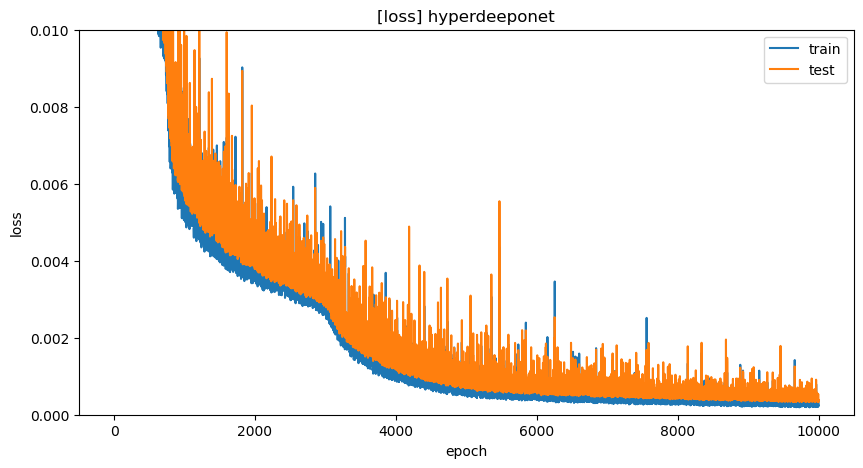

In [165]:
X = range(len(loss_dict['train_loss']))
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)  
plt.plot(X, loss_dict['train_loss'], label='train')
plt.plot(X, loss_dict['test_loss'], label='test')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("[loss] "+model_name)
plt.ylim(0,0.01)
plt.legend()

Text(0.5, 1.0, '[train loss] hyperdeeponet')

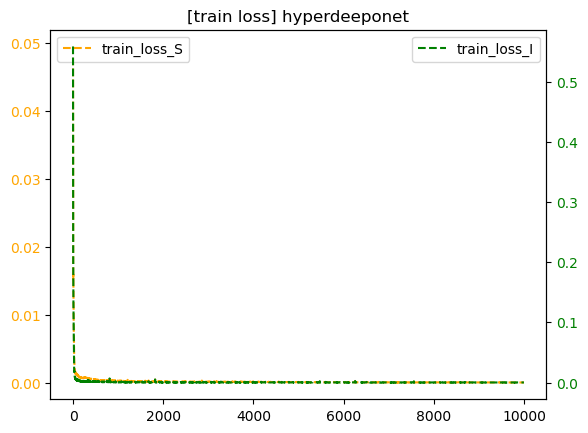

In [166]:
X = range(len(loss_dict['train_loss']))
fig, ax = plt.subplots()
plt.plot(X, loss_dict['train_loss_S'], '--',color='orange', label='train_loss_S')
ax.tick_params(axis='y', labelcolor='orange')
plt.legend(loc=2)

ax2 = ax.twinx()
plt.plot(X, loss_dict['train_loss_I'], '--',color='green',label='train_loss_I')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc=0)
plt.title("[train loss] "+model_name)

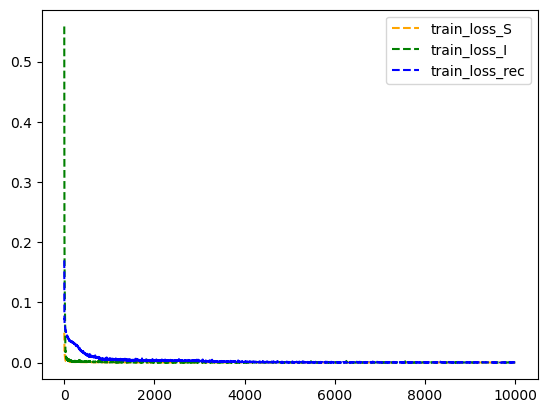

In [167]:
plt.plot(X, loss_dict['train_loss_S'], '--',color='orange', label='train_loss_S')
plt.plot(X, np.array(loss_dict['train_loss_I']), '--',color='green',label='train_loss_I')
plt.plot(X, np.array(loss_dict['train_loss_rec']), '--',color='blue',label='train_loss_rec')
plt.legend()

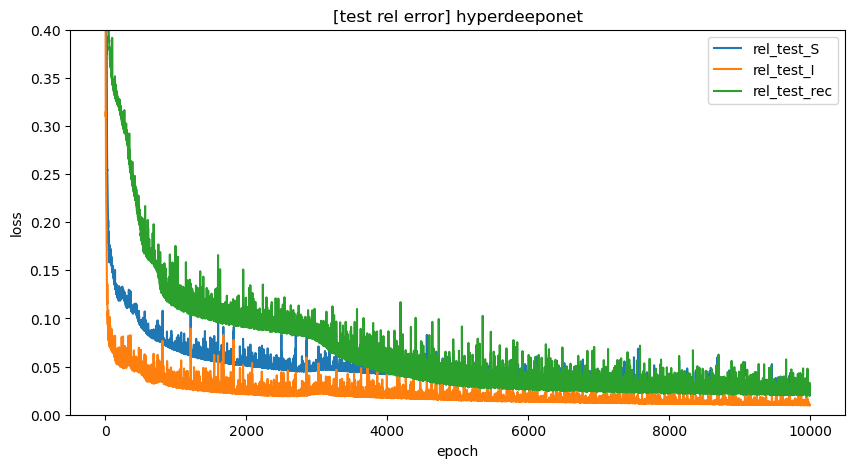

In [168]:
X = range(len(loss_dict['train_loss']))
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)  
plt.plot(X, loss_dict['rel_test_S'], label='rel_test_S')
plt.plot(X, loss_dict['rel_test_I'], label='rel_test_I')
plt.plot(X, loss_dict['rel_test_rec'], label='rel_test_rec')
plt.ylim(0,0.4)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("[test rel error] "+model_name)
plt.legend()

## inference 1 sample

In [172]:
N = 1000
M = args.n_sensor
D = np.linspace(0, T, M) # sensor
interp = 11
data_name=args.data+'_N'+str(N)+'_M'+str(M)+'_int'+str(interp)+'.pickle'

In [173]:
with open(os.path.join("data_generation",data_name),"rb") as fr:
    load_data= pickle.load(fr)
    print(data_name, 'is loaded')
print(load_data['train_X'].shape,load_data['train_Y'].shape,load_data['test_X'].shape,load_data['test_Y'].shape)

if 'T' not in load_data:
    load_data['T'] = 1
if 'S0' not in load_data:
    load_data['S0'] = 1
if 'I0' not in load_data:
    load_data['I0'] = 1

SIR_v4_rec_N1000_M121_int11.pickle is loaded
torch.Size([121000, 122]) torch.Size([121000, 3]) torch.Size([24200, 122]) torch.Size([24200, 3])


In [174]:
def load_model(model, state_dict):
    if args.multgpu:
        new_keys = []
        for key in state_dict.keys():
            new_key = key[7:]    # remove the 'module.'
            new_keys.append(new_key)
        new_values = OrderedDict(list(zip(new_keys, state_dict.values())))
        model.load_state_dict(new_values)
        print('multi gpu model is loaded')
    else:
        model.load_state_dict(state_dict)
        print('single gpu model is loaded')
    return model

In [175]:
model=select_model(args.model)(
                args.d_target,
                args.w_target,
                args.a_target,
                args.d_hyper,
                args.w_hyper,
                args.a_hyper,    
                args.n_sensor,
                args.d_in,
                args.n_basis,
                args.d_out
            ).cuda()
model = load_model(model, state_dict)

single gpu model is loaded


In [176]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

S0 = 350
I0 = 10 
R0 = 2.5 # basic reproduction number
gamma  = 0.25
beta = R0*gamma/S0

x0 = (S0,I0) # initial condition

def func(t,Y,u): # Y[0] = S, Y[1] = I
    return -beta*Y[0]*Y[1]-u(t)*Y[0], beta*Y[0]*Y[1]-gamma*Y[1]

In [94]:
# for name, param in model.named_parameters():
#     print(name, param)

hyper_list.0.weight Parameter containing:
tensor([[-0.0739, -0.1578, -0.1284,  ..., -0.0530, -0.0359, -0.0029],
        [ 0.1020,  0.1588, -0.0091,  ..., -0.0356, -0.0229,  0.0610],
        [-0.0350, -0.0591, -0.0936,  ..., -0.0525, -0.0843,  0.0650],
        ...,
        [ 0.0554,  0.0364,  0.0360,  ..., -0.0133, -0.0486, -0.0122],
        [-0.2160, -0.1251, -0.2746,  ..., -0.0590, -0.0167, -0.0341],
        [-0.2737, -0.1475, -0.2584,  ..., -0.2403, -0.4006, -0.3804]],
       device='cuda:0', requires_grad=True)
hyper_list.0.bias Parameter containing:
tensor([ 0.0025,  0.1418, -0.2609,  0.4940, -0.1302, -0.0323,  0.0100,  0.0076,
        -0.0362,  1.3846, -0.0689, -0.0681,  0.1358,  0.0258, -0.1358, -0.3414,
        -0.3279, -0.0435, -0.3317, -0.4069], device='cuda:0',
       requires_grad=True)
hyper_list.2.weight Parameter containing:
tensor([[-0.1905,  0.0949, -0.1008,  0.0015,  0.0941,  0.1133,  0.2142, -0.1077,
          0.1185, -0.1611, -0.0042,  0.1340, -0.2913, -0.0105, -0.31

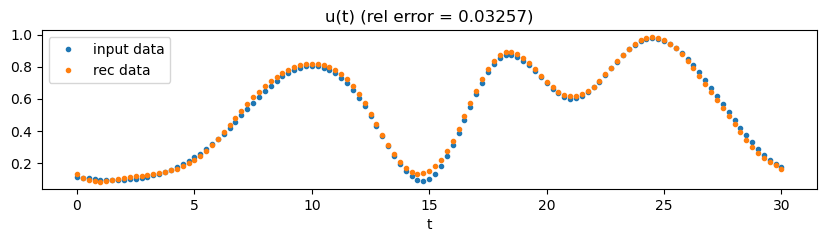

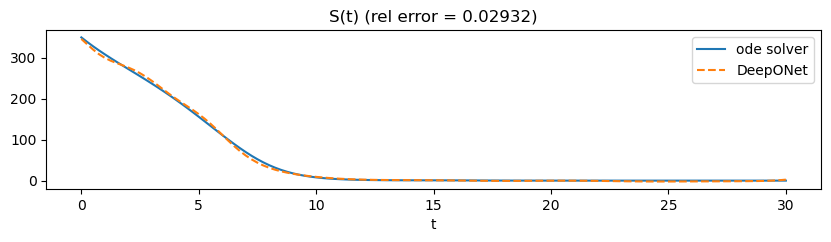

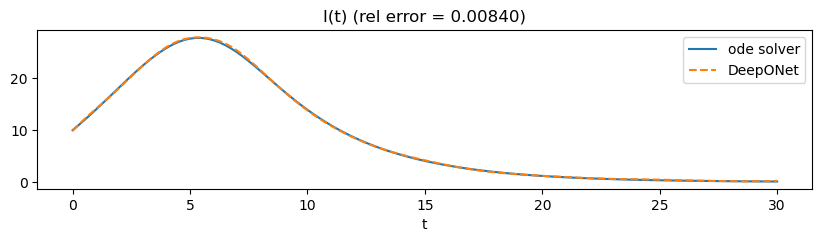

In [185]:
idx=np.random.randint(0,200)

x=load_data['test_X'][M*idx][:M]
y=load_data['test_Y'][M*idx:M*idx+M]

y[:,0] = y[:,0]*load_data['S0']
y[:,1] = y[:,1]*load_data['I0']

u = interp1d(D, x, kind='cubic')
#sol = solve_ivp(func, (0,T), x0, method='RK45',t_eval=D,args=(u,))

xnew = np.linspace(0, T, 10*M) # for viz
ynew = u(xnew) # for viz

test_x = []
for j in D:
    test_x.append(np.append(x, j/load_data['T']))
test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()
pred=model(test_x[:,M:].cuda(),test_x[:,:M].cuda()).detach().cpu()

pred[:,0] = pred[:,0]*load_data['S0']
pred[:,1] = pred[:,1]*load_data['I0']

rel_u = rel_L2_error(x,pred[:,-1]).item()
rel_S = rel_L2_error(pred[:,0],y[:,0]).item()
rel_I = rel_L2_error(pred[:,1],y[:,1]).item()

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)  
#plt.plot(xnew, ynew,'--',color='gray',) # interp 적용 안됨
plt.plot(D, x, 'o',markersize=3, label='input data')
plt.xlabel('t')
plt.title('u(t)')

if pred.shape[-1] == 3:
    plt.plot(D, pred[:,-1], 'o',markersize=3,label='rec data')
    plt.title("u(t) (rel error = %.5f)"%(rel_u))

plt.legend()

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 2)  
plt.plot(D, y[:,0],label='ode solver',markersize=3)
plt.plot(D, pred[:,0],'--',label='DeepONet',markersize=3)
plt.title("S(t) (rel error = %.5f)"%(rel_S))

plt.xlabel('t')
plt.legend()

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 3)  
plt.plot(D, y[:,1],label='ode solver',markersize=3)
plt.plot(D, pred[:,1],'--',label='DeepONet',markersize=3)
plt.title("I(t) (rel error = %.5f)"%(rel_I))

plt.xlabel('t')
plt.legend()
#plt.legend()

- 여러 모델 한번에 viz

In [ ]:
for name in tqdm(names):
    path=os.path.join('results',name)
    args=torch.load(os.path.join(path,'args.bin'))
    state_dict=torch.load(os.path.join(path,'weight.bin'))
    loss_dict=torch.load(os.path.join(path,'loss.bin'))
    model_name = 'small '+args.model if 'small' in name else args.model
    model = select_model(args.model)(
                args.d_target,
                args.w_target,
                args.a_target,
                args.d_hyper,
                args.w_hyper,
                args.a_hyper,    
                args.n_sensor,
                args.d_in,
                args.n_basis,
                args.d_out
            ).cuda()
    model = load_model(model, state_dict)
    test_x = []
    x = func_u(D)

    for j in D:
        test_x.append(np.append(x, j))

    test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()

    y2=model(test_x[:,M:].cuda(),test_x[:,:M].cuda()).reshape(-1).detach().cpu()
    result_dict[model_name] = y2

In [ ]:
y1 = odeint(test_func, x0, D) # ode solver

plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)  

plt.plot(D, y1, label='ode solver')
for key,val in result_dict.items():
    plt.plot(D, val, label=key, linestyle='--')

#plt.xlim(0,1)
#plt.ylim(0,2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(t)=1+t+t**2')
plt.legend()